In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from utils import view_data, view_data_rand

# Benchmarking STN vs What/Where model

- The eccentricites that the networks were trained on:

In [2]:
eccentricities = np.array([
    4.44444444, 8.88888889, 13.33333333, 17.77777778, 22.22222222, 26.66666667,
    31.11111111, 35.55555556, 40.
])

In [3]:
contrasts = (0.7, 0.5, 0.3)

- The following What/Where accuracy statistics were recuperated from the original What/Where repo, from this [notebook](https://github.com/laurentperrinet/WhereIsMyMNIST/blob/master/notebooks/4_results_figure_contrast.ipynb) specifically

In [4]:
what_where_stats = {
    0.3: {
        0:
        np.array(
            [0.093, 0.115, 0.103, 0.103, 0.131, 0.182, 0.342, 0.455, 0.528]),
        1:
        np.array(
            [0.164, 0.234, 0.252, 0.318, 0.368, 0.397, 0.466, 0.512, 0.538]),
        2:
        np.array(
            [0.197, 0.258, 0.341, 0.325, 0.411, 0.436, 0.47, 0.501, 0.538]),
        3:
        np.array(
            [0.21, 0.261, 0.323, 0.357, 0.416, 0.438, 0.453, 0.509, 0.506]),
        4:
        np.array(
            [0.224, 0.282, 0.326, 0.33, 0.359, 0.444, 0.453, 0.498, 0.484]),
        5:
        np.array(
            [0.204, 0.288, 0.319, 0.341, 0.347, 0.404, 0.462, 0.47, 0.476])
    },
    0.5: {
        0:
        np.array(
            [0.111, 0.105, 0.127, 0.108, 0.151, 0.306, 0.478, 0.699, 0.823]),
        1:
        np.array(
            [0.422, 0.537, 0.566, 0.625, 0.66, 0.717, 0.762, 0.811, 0.833]),
        2:
        np.array(
            [0.493, 0.608, 0.649, 0.678, 0.728, 0.776, 0.78, 0.799, 0.804]),
        3:
        np.array(
            [0.502, 0.607, 0.657, 0.706, 0.715, 0.765, 0.79, 0.789, 0.792]),
        4:
        np.array(
            [0.526, 0.631, 0.649, 0.721, 0.719, 0.747, 0.791, 0.792, 0.789]),
        5:
        np.array(
            [0.523, 0.602, 0.651, 0.686, 0.737, 0.752, 0.787, 0.78, 0.805])
    },
    0.7: {
        0:
        np.array(
            [0.111, 0.112, 0.102, 0.104, 0.159, 0.287, 0.532, 0.756, 0.899]),
        1:
        np.array([0.628, 0.672, 0.714, 0.724, 0.777, 0.782, 0.859, 0.879,
                  0.9]),
        2:
        np.array(
            [0.703, 0.765, 0.786, 0.824, 0.836, 0.86, 0.879, 0.879, 0.872]),
        3:
        np.array([0.729, 0.781, 0.809, 0.83, 0.838, 0.857, 0.854, 0.89,
                  0.875]),
        4:
        np.array(
            [0.714, 0.777, 0.814, 0.826, 0.856, 0.869, 0.876, 0.884, 0.877]),
        5:
        np.array([0.74, 0.8, 0.823, 0.833, 0.842, 0.854, 0.872, 0.866, 0.886])
    }
}

- The performance of the pure STN_128x128 was recuperated from the notebook **"STN_128x128"** where the network was trained and tested.

In [5]:
stn_stats = {
    0.7:
    np.array([
        0.9715, 0.9657, 0.9628, 0.965, 0.9623, 0.9621, 0.9572, 0.9548, 0.9558
    ]),
    0.5:
    np.array([
        0.9548, 0.9553, 0.9539, 0.9533, 0.9509, 0.9433, 0.9483, 0.9424, 0.9433
    ]),
    0.3:
    np.array([
        0.7656, 0.7598, 0.7455, 0.7433, 0.7367, 0.7242, 0.7422, 0.7437, 0.6892
    ])
}

- The performance of the Attention transformer network (Spatial transformer parametrized for attention with downsampling in the grid sampler) was recuperated from the notebook **downsampling_attention_stn"** where the network was trained and tested.

In [6]:
atn_stats = {
    0.7:
    np.array([
        0.9606, 0.9509, 0.9417, 0.9324, 0.9224, 0.9218, 0.9147, 0.9335, 0.9456
    ]),
    0.5:
    np.array([
        0.9314, 0.9316, 0.9248, 0.9334, 0.9258, 0.9152, 0.9177, 0.9179, 0.9264
    ]),
    0.3:
    np.array([
        0.7122, 0.6868, 0.676, 0.6779, 0.6871, 0.6744, 0.6549, 0.6768, 0.6111
    ])
}

- The performance of the Polo Attention transformer network (Spatial transformer parametrized for attention with downsampling in the grid sampler with log polar input) was recuperated from the notebook **stn_128x128-POLO-tests"** where the network was trained and tested.

In [7]:
polo_atn_stats = {
    0.7:
    np.array([
        0.8654, 0.8457, 0.8002, 0.7282, 0.6109, 0.4977, 0.4231, 0.3836, 0.3362
    ]),
    0.5:
    np.array([
        0.7733, 0.7443, 0.6974, 0.6212, 0.5517, 0.4665, 0.3947, 0.3196, 0.2394
    ]),
    0.3:
    np.array([
        0.4094, 0.3913, 0.3405, 0.2858, 0.248, 0.2055, 0.1752, 0.1487, 0.1151
    ])
}

In [9]:
polo_atn_stats_2 = {
    0.7:
    np.array([
        0.8658, 0.8503, 0.7641, 0.6651, 0.533, 0.4472, 0.3875, 0.3247, 0.2542
    ]),
    0.5:
    np.array([
        0.7786, 0.7471, 0.6867, 0.5807, 0.4809, 0.4076, 0.3247, 0.2402, 0.1672
    ]),
    0.3:
    np.array(
        [0.4538, 0.4296, 0.356, 0.299, 0.2478, 0.1969, 0.1532, 0.1268, 0.1115])
}

# Plotting

In [11]:
plt.style.use("gadfly")

In [12]:
cols = [
    "#E1BC29", "#042a2b", "#5eb1bf", "#cdedf6", "#ef7b45", "#d84727", "#7768AE"
]

labs = [
    "What/Where 0 saccades", "What/Where 1 saccade", "Spatial Transformer Net",
    "Attention Transformer Net", "POLO-Attention Transformer Net" , "low POLO-Attention Transformer Net"
]

Text(0.5, 0.98, 'Spatial Transformer Networks Vs. the What/Where Model - 128x128 pixels Noisy MNIST \nAccuracy as a function of eccentricity and contrast')

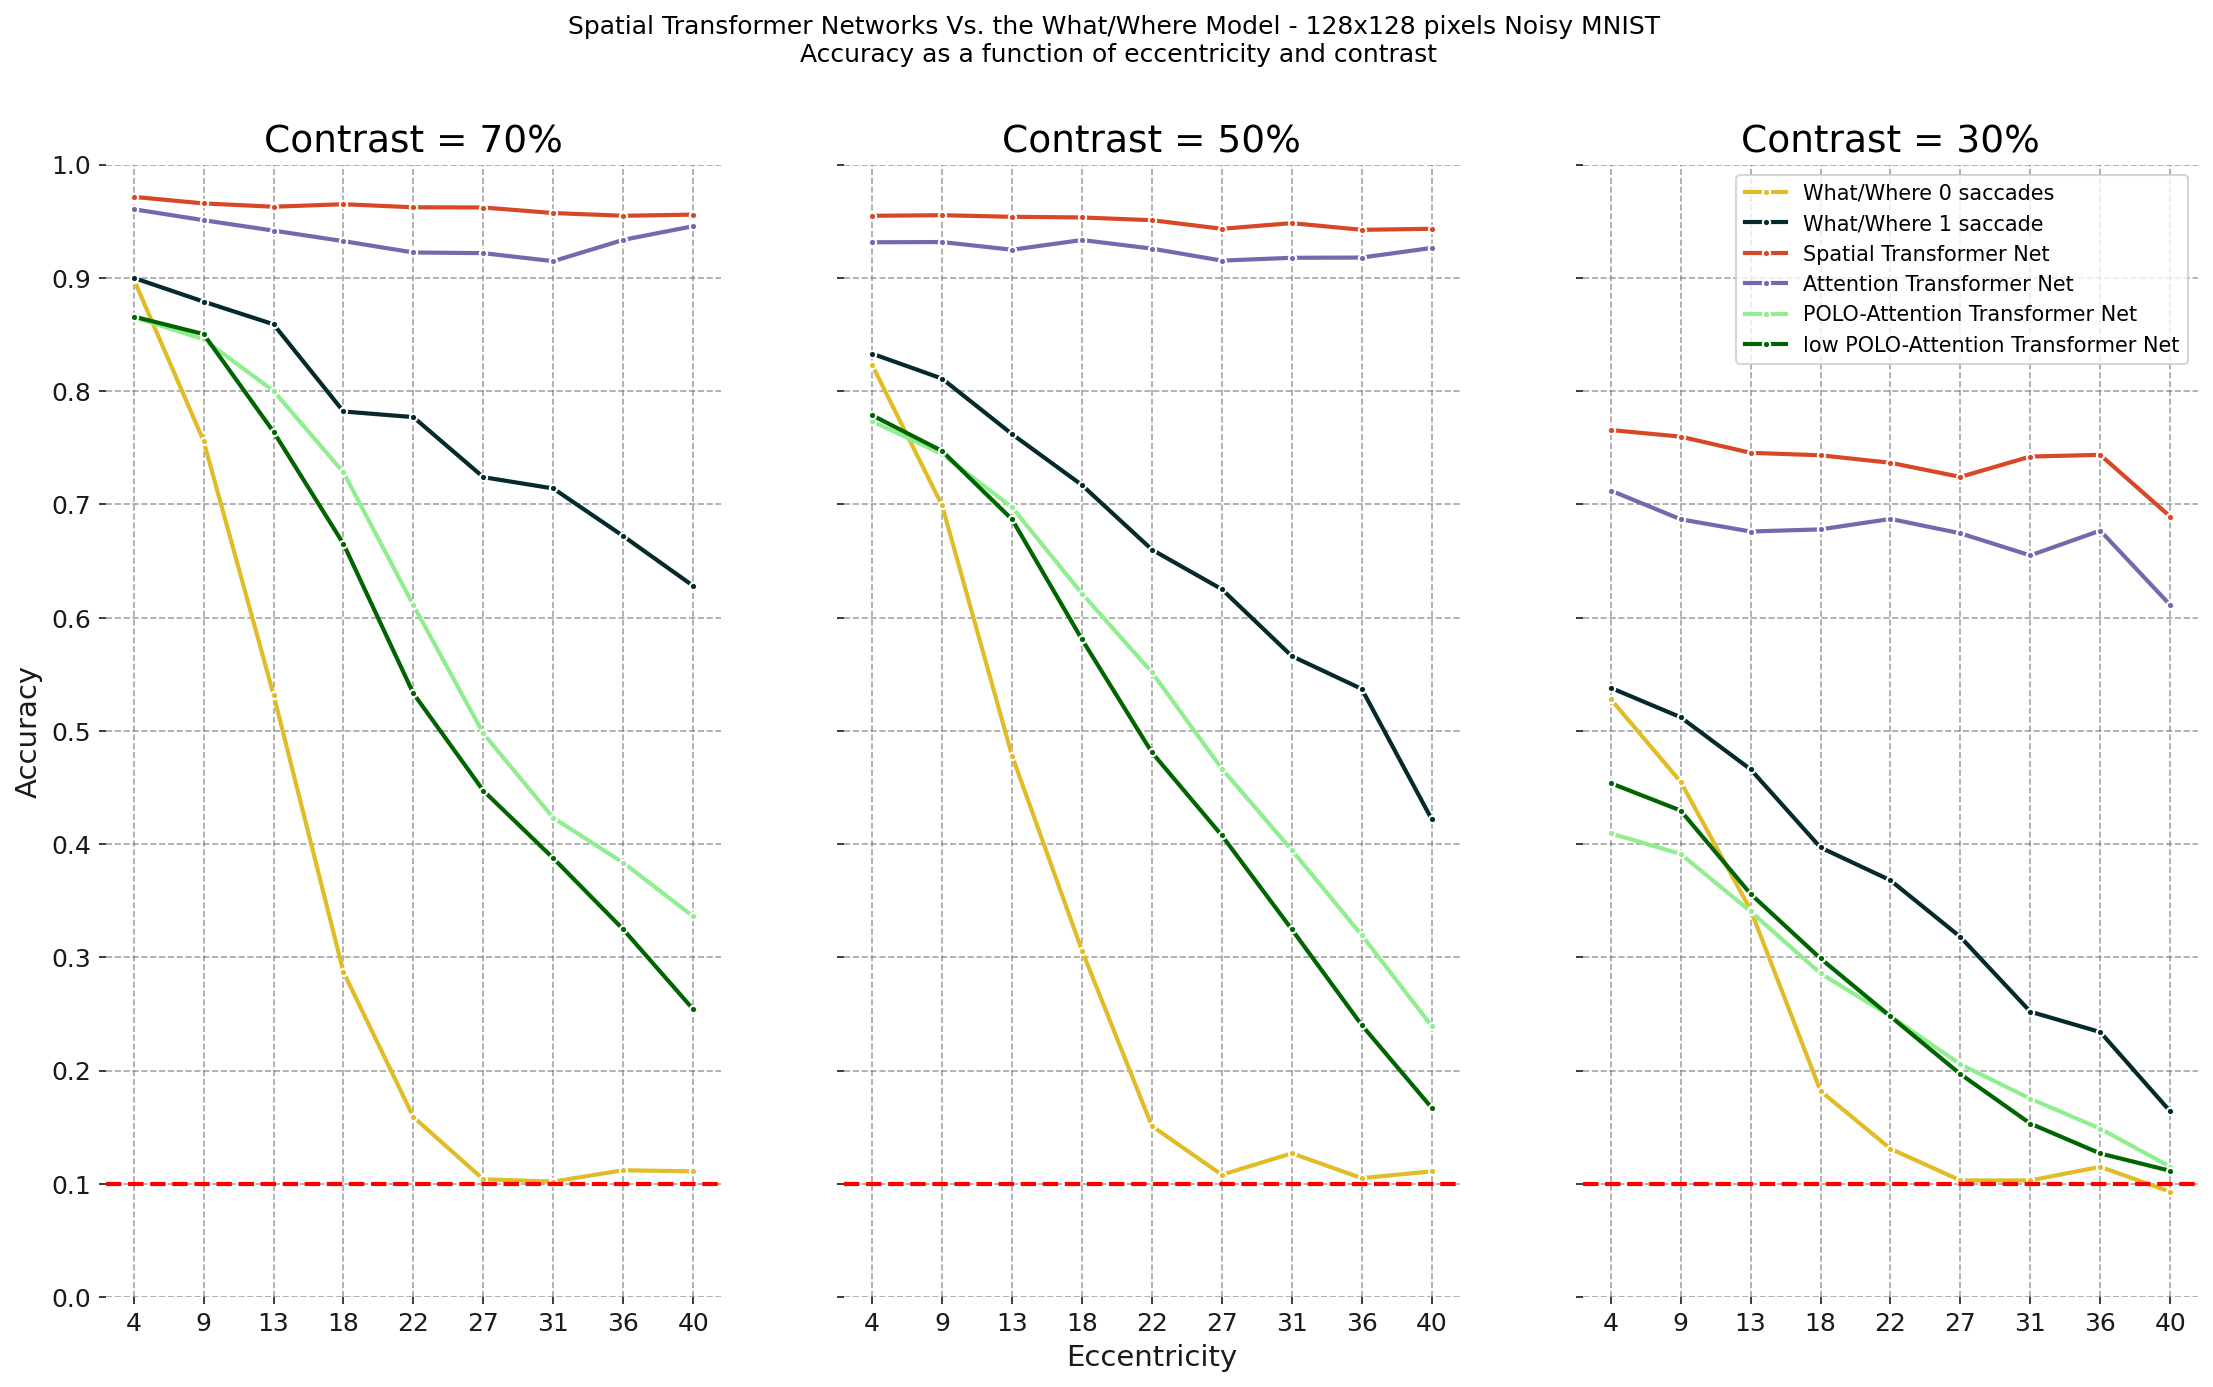

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10), dpi=150)

for i, contrast in enumerate(contrasts): # three plots for three contrasts

    # plot all what/where model stats
    for j in range(2): # all saccades per plot

        ax[i].plot(eccentricities,
                   what_where_stats[contrast][j][::-1],
                   '.-',
                   color=cols[j],
                   label=labs[j])
    # plot the stn results
    ax[i].plot(eccentricities, 
               stn_stats[contrast],
               '.-',
               color=cols[5],
               label=labs[2])
    # plot the atn results
    ax[i].plot(eccentricities,
           atn_stats[contrast],
           '.-',
           color=cols[6],
           label=labs[3])
    
    # plot the polo-atn results
    ax[i].plot(eccentricities,
           polo_atn_stats[contrast],
           '.-',
           color="lightgreen",
           label=labs[4])
    
    ax[i].plot(eccentricities,
           polo_atn_stats_2[contrast],
           '.-',
           color="darkgreen",
           label=labs[5])

    ax[i].set_ylim(0, 1) # accuracy limits
    ax[i].set_title("Contrast = %d%%" % (contrast * 100))
    ax[i].set_xticklabels([4, 9, 13, 18, 22, 27, 31, 36, 40]) # rounding labels up
    ax[i].set_xticks(eccentricities)
    ax[i].axhline(y=0.1, color='r', linestyle='--') # baseline
    ax[i].set_yticks([a/10 for a in range(11)]) #accuracy ticks

    if i > 0:
        ax[i].set_yticklabels([])

ax[2].legend() # show legend on 3rd plot
ax[1].set_xlabel("Eccentricity")
ax[0].set_ylabel("Accuracy")
fig.suptitle(
    "Spatial Transformer Networks Vs. the What/Where Model - 128x128 pixels Noisy MNIST \nAccuracy as a function of eccentricity and contrast"
)
#fig.savefig('../figures/benchmark.png')